In [ ]:
!pip install datasets

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import AutoTokenizer

In [ ]:
class ConvAttnModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, kernel_size=3, num_heads=4):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, embed_dim, kernel_size, padding=kernel_size//2)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.out = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embed(x).transpose(1, 2)
        x = F.relu(self.conv(x)).transpose(1, 2)
        x, attn_weights = self.attn(x, x, x, need_weights=True)
        return self.out(x), attn_weights

In [ ]:
class AttnAttnModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.attn1 = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.attn2 = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.out = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        x, attn_weights1 = self.attn1(x, x, x, need_weights=True)
        x, attn_weights2 = self.attn2(x, x, x, need_weights=True)
        return self.out(x), (attn_weights1, attn_weights2)

In [ ]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total_tokens = 0

    for batch in dataloader:
        x = batch['input_ids'][:, :-1].to(device)
        y = batch['input_ids'][:, 1:].to(device)

        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = logits.argmax(dim=-1)
        correct += (predictions == y).sum().item()
        total_tokens += y.numel()

    accuracy = correct / total_tokens
    return total_loss / len(dataloader), accuracy


In [ ]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask"])
dataloader = DataLoader(tokenized_datasets["train"], batch_size=32, shuffle=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [ ]:
vocab_size = tokenizer.vocab_size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_model = ConvAttnModel(vocab_size).to(device)
attn_model = AttnAttnModel(vocab_size).to(device)

optimizer_conv = optim.AdamW(conv_model.parameters(), lr=1e-3)
optimizer_attn = optim.AdamW(attn_model.parameters(), lr=2e-3)

criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 25
conv_losses, conv_accuracies = [], []
attn_losses, attn_accuracies = [], []

In [ ]:
for epoch in range(num_epochs):
    loss, acc = train(conv_model, dataloader, optimizer_conv, criterion, device)
    conv_losses.append(loss)
    conv_accuracies.append(acc)
    print(f"[Conv-Attn] Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    loss, acc = train(attn_model, dataloader, optimizer_attn, criterion, device)
    attn_losses.append(loss)
    attn_accuracies.append(acc)
    print(f"[Attn-Attn] Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

[Conv-Attn] Epoch 1, Loss: 1.3955, Accuracy: 0.8194
[Attn-Attn] Epoch 1, Loss: 2.5709, Accuracy: 0.6760
[Conv-Attn] Epoch 2, Loss: 0.3248, Accuracy: 0.9486
[Attn-Attn] Epoch 2, Loss: 2.1920, Accuracy: 0.6964
[Conv-Attn] Epoch 3, Loss: 0.1542, Accuracy: 0.9728
[Attn-Attn] Epoch 3, Loss: 2.0288, Accuracy: 0.7045
[Conv-Attn] Epoch 4, Loss: 0.0935, Accuracy: 0.9821
[Attn-Attn] Epoch 4, Loss: 1.9140, Accuracy: 0.7098
[Conv-Attn] Epoch 5, Loss: 0.0625, Accuracy: 0.9875
[Attn-Attn] Epoch 5, Loss: 1.8202, Accuracy: 0.7143
[Conv-Attn] Epoch 6, Loss: 0.0479, Accuracy: 0.9900
[Attn-Attn] Epoch 6, Loss: 1.7424, Accuracy: 0.7184
[Conv-Attn] Epoch 7, Loss: 0.0390, Accuracy: 0.9919
[Attn-Attn] Epoch 7, Loss: 1.6773, Accuracy: 0.7220
[Conv-Attn] Epoch 8, Loss: 0.0334, Accuracy: 0.9930
[Attn-Attn] Epoch 8, Loss: 1.6217, Accuracy: 0.7254
[Conv-Attn] Epoch 9, Loss: 0.0292, Accuracy: 0.9939
[Attn-Attn] Epoch 9, Loss: 1.5728, Accuracy: 0.7284
[Conv-Attn] Epoch 10, Loss: 0.0256, Accuracy: 0.9948
[Attn-Attn]

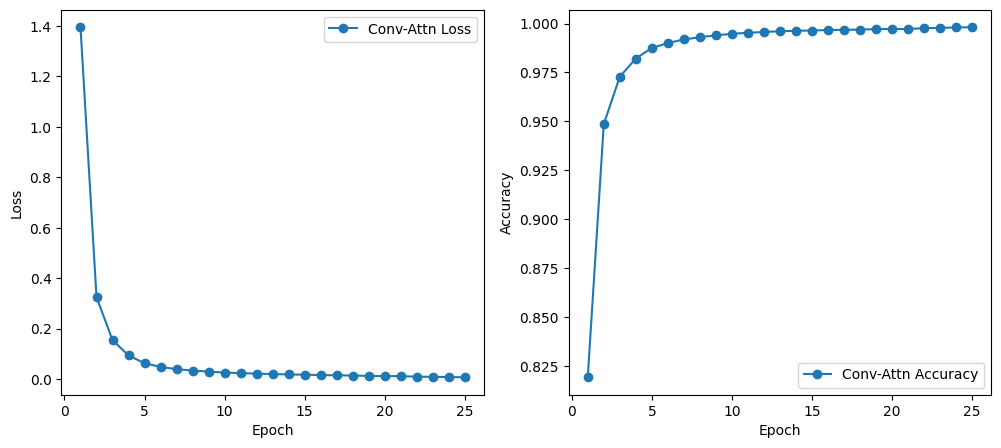

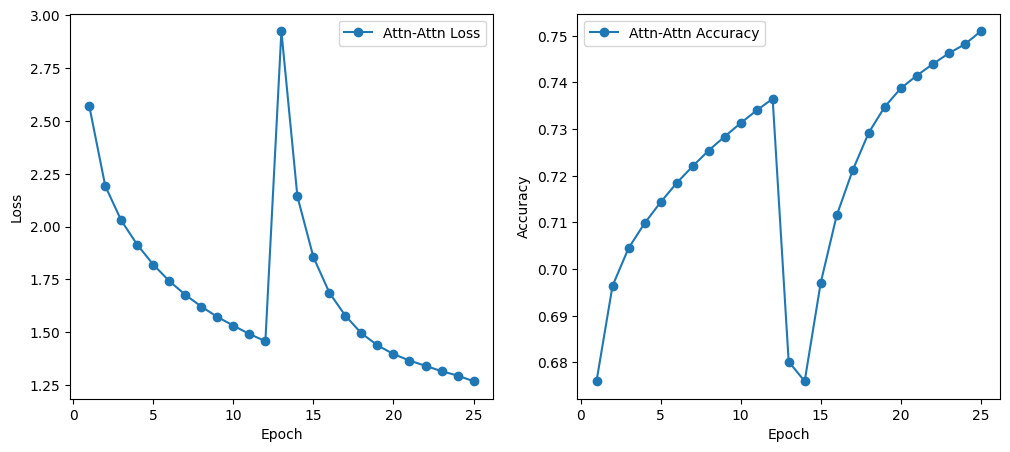

In [ ]:
def plot_metrics(losses, accuracies, label):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), losses, marker='o', label=f'{label} Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), accuracies, marker='o', label=f'{label} Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

plot_metrics(conv_losses, conv_accuracies, "Conv-Attn")
plot_metrics(attn_losses, attn_accuracies, "Attn-Attn")

In [ ]:
def plot_conv_weights(model):
    weights = model.conv.weight.detach().cpu().numpy()
    avg_weights = np.mean(weights, axis=1)
    plt.figure(figsize=(10, 5))
    sns.heatmap(avg_weights, cmap="coolwarm", center=0)
    plt.title("Convolutional Layer Weights")
    plt.show()

def plot_attention_maps(model, tokenizer, text, att_c = 0):
    tokens = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model(tokens["input_ids"])

    if isinstance(output, tuple) and len(output) == 2:
        logits, attn_weights = output
    else:
        raise ValueError("Модель не вернула карты внимания.")

    attn_weights = attn_weights[att_c].cpu().numpy().squeeze()

    plt.figure(figsize=(8, 8))
    sns.heatmap(attn_weights, cmap="Blues", square=True)
    plt.title("Attention Map")
    plt.show()

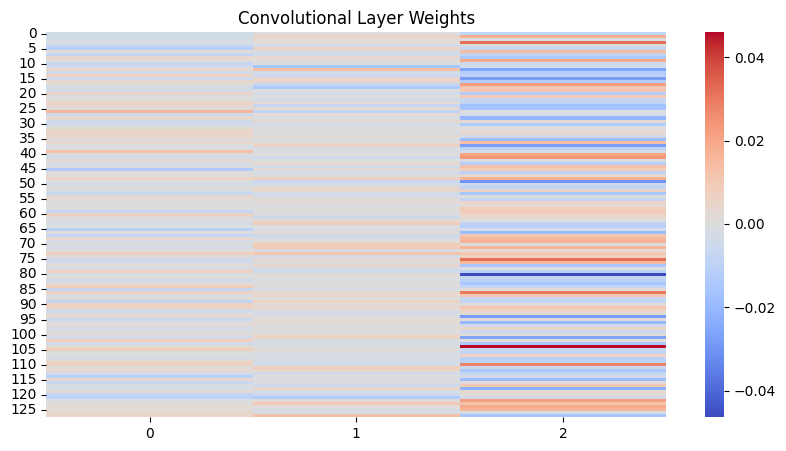

In [ ]:
plot_conv_weights(conv_model)

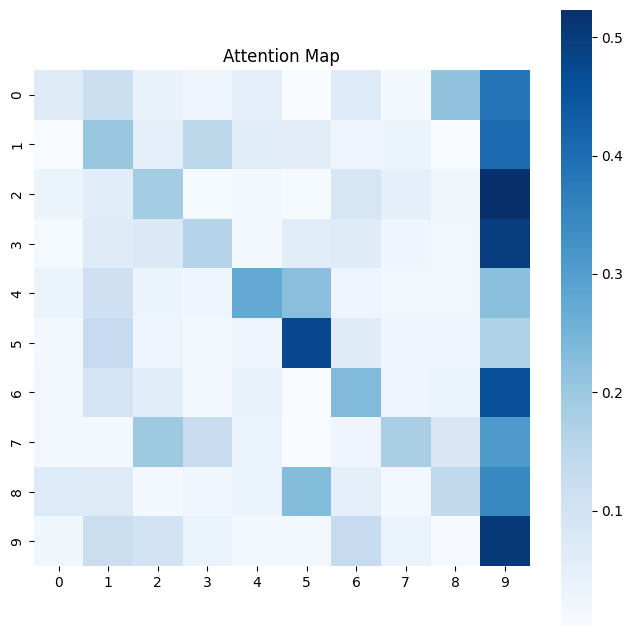

In [ ]:
plot_attention_maps(conv_model, tokenizer, "The quick brown fox jumps over the lazy dog.")

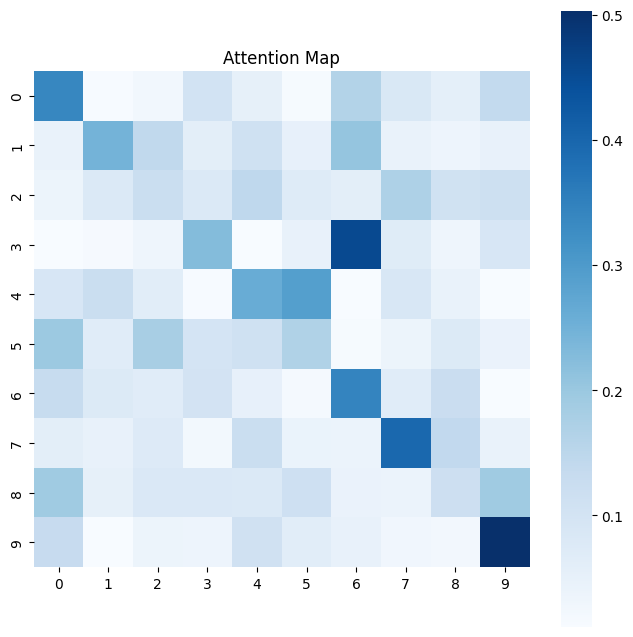

In [ ]:
plot_attention_maps(attn_model, tokenizer, "The quick brown fox jumps over the lazy dog.")

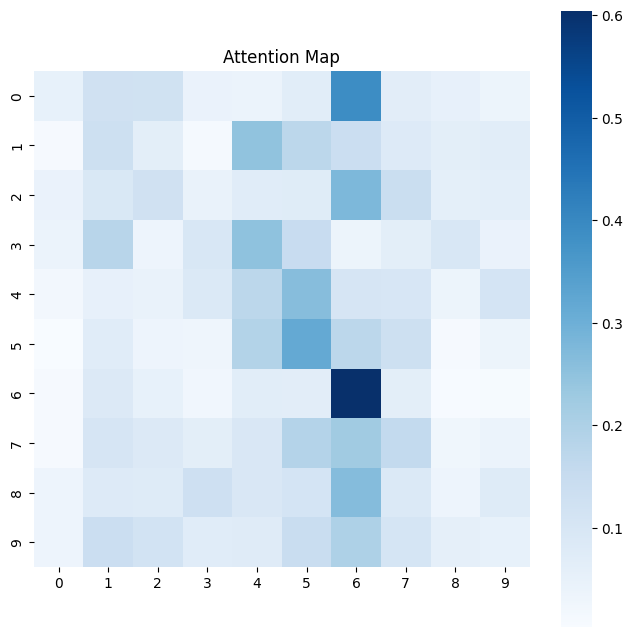

In [ ]:
plot_attention_maps(attn_model, tokenizer, "The quick brown fox jumps over the lazy dog.", 1)